# Q3. DeBlur Images with DeblurGanV2 (20 pts)

Tóm tắt vấn đề: Deblur ảnh với DeBlurGanV2
Cho thư mục “samples” chứa 4 hình ảnh bị mờ: '000247.png', '000189.png', '000619.png', '002127.png'
Yêu cầu :
1. Tận dụng kiến thức về deconvolution và mô hình DeblurGanV2, hãy tiến hành deblur (Làm nét) các ảnh trên. Visualize kết quả trước và sau khi deblur.
2. Tiến hành tính toán độ sắc nét (sharpness) của hình ảnh trước và sau khi được deblur Visualize kết quả kèm theo độ sắc nét của hình ảnh trước và sau khi deblur như hình bên dưới. Tính toán (%) sharpness change theo công thức bên dưới và đánh giá kết quả thu được.

(%) sharpness change = (deblurred sharpness -original sharpness)/ original_sharpness

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!mkdir -p /content/dataset
!cp /gdrive/MyDrive/ComputerVision/Yolo/archive.zip /content/dataset/
%cd /content/dataset/
!unzip -qq archive.zip

cp: cannot stat '/gdrive/MyDrive/ComputerVision/Yolo/archive.zip': No such file or directory
/content/dataset
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


# 1. Tiến hành deblur (Làm nét) các ảnh

In [3]:
# check gpu
!nvidia-smi

Mon Jan 29 18:05:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Setup Packages and Environment

### Deblur with MobileNet

In [4]:
#@title Installing and downloading models
%cd /content/
!git clone https://github.com/styler00dollar/Colab-DeblurGANv2
!pip install fire
!pip install pretrainedmodels
!pip install gdown
%cd /content/Colab-DeblurGANv2/models
!gdown --id 1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR
!wget --no-check-certificate http://sceneparsing.csail.mit.edu/model/pretrained_resnet/mobilenet_v2.pth.tar
!gdown --id 1JhnT4BBeKBBSLqTo6UsJ13HeBXevarrU

/content
Cloning into 'Colab-DeblurGANv2'...
remote: Enumerating objects: 835, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 835 (delta 118), reused 117 (delta 117), pack-reused 608
Receiving objects: 100% (835/835), 61.79 MiB | 22.09 MiB/s, done.
Resolving deltas: 100% (442/442), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=370fced1a058fd84b668d0f3512e38714c3a5d74b7a29d541509c4bb4df00836
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=174a69889f

In [5]:
#@title Changing config.yaml
%%writefile /content/Colab-DeblurGANv2/config/config.yaml
---
project: deblur_gan
experiment_desc: fpn

train:
  files_a: &FILES_A /datasets/my_dataset/**/*.jpg
  files_b: *FILES_A
  size: &SIZE 256
  crop: random
  preload: &PRELOAD false
  preload_size: &PRELOAD_SIZE 0
  bounds: [0, .9]
  scope: geometric
  corrupt: &CORRUPT
    - name: cutout
      prob: 0.5
      num_holes: 3
      max_h_size: 25
      max_w_size: 25
    - name: jpeg
      quality_lower: 70
      quality_upper: 90
    - name: motion_blur
    - name: median_blur
    - name: gamma
    - name: rgb_shift
    - name: hsv_shift
    - name: sharpen

val:
  files_a: *FILES_A
  files_b: *FILES_A
  size: *SIZE
  scope: geometric
  crop: center
  preload: *PRELOAD
  preload_size: *PRELOAD_SIZE
  bounds: [.9, 1]
  corrupt: *CORRUPT

phase: train
warmup_num: 3
model:
  g_name: fpn_mobilenet
  blocks: 9
  d_name: double_gan # may be no_gan, patch_gan, double_gan, multi_scale
  d_layers: 3
  content_loss: perceptual
  adv_lambda: 0.001
  disc_loss: wgan-gp
  learn_residual: True
  norm_layer: instance
  dropout: True

num_epochs: 200
train_batches_per_epoch: 1000
val_batches_per_epoch: 100
batch_size: 1
image_size: [256, 256]

optimizer:
  name: adam
  lr: 0.0001
scheduler:
  name: linear
  start_epoch: 50
  min_lr: 0.0000001

Overwriting /content/Colab-DeblurGANv2/config/config.yaml


In [6]:
#@title Changing predict.py
%%writefile /content/Colab-DeblurGANv2/predict.py
import os
from glob import glob
from typing import Optional

import cv2
import numpy as np
import torch
import yaml
from fire import Fire
from tqdm import tqdm

from aug import get_normalize
from models.networks import get_generator


class Predictor:
    def __init__(self, weights_path: str, model_name: str = ''):
        with open('config/config.yaml') as cfg:
            config = yaml.load(cfg,Loader=yaml.FullLoader)
        model = get_generator(model_name or config['model'])
        model.load_state_dict(torch.load(weights_path)['model'])
        self.model = model.cuda()
        self.model.train(True)
        # GAN inference should be in train mode to use actual stats in norm layers,
        # it's not a bug
        self.normalize_fn = get_normalize()

    @staticmethod
    def _array_to_batch(x):
        x = np.transpose(x, (2, 0, 1))
        x = np.expand_dims(x, 0)
        return torch.from_numpy(x)

    def _preprocess(self, x: np.ndarray, mask: Optional[np.ndarray]):
        x, _ = self.normalize_fn(x, x)
        if mask is None:
            mask = np.ones_like(x, dtype=np.float32)
        else:
            mask = np.round(mask.astype('float32') / 255)

        h, w, _ = x.shape
        block_size = 32
        min_height = (h // block_size + 1) * block_size
        min_width = (w // block_size + 1) * block_size

        pad_params = {'mode': 'constant',
                      'constant_values': 0,
                      'pad_width': ((0, min_height - h), (0, min_width - w), (0, 0))
                      }
        x = np.pad(x, **pad_params)
        mask = np.pad(mask, **pad_params)

        return map(self._array_to_batch, (x, mask)), h, w

    @staticmethod
    def _postprocess(x: torch.Tensor) -> np.ndarray:
        x, = x
        x = x.detach().cpu().float().numpy()
        x = (np.transpose(x, (1, 2, 0)) + 1) / 2.0 * 255.0
        return x.astype('uint8')

    def __call__(self, img: np.ndarray, mask: Optional[np.ndarray], ignore_mask=True) -> np.ndarray:
        (img, mask), h, w = self._preprocess(img, mask)
        with torch.no_grad():
            inputs = [img.cuda()]
            if not ignore_mask:
                inputs += [mask]
            pred = self.model(*inputs)
        return self._postprocess(pred)[:h, :w, :]

def process_video(pairs, predictor, output_dir):
    for video_filepath, mask in tqdm(pairs):
        video_filename = os.path.basename(video_filepath)
        output_filepath = os.path.join(output_dir, os.path.splitext(video_filename)[0]+'_deblur.mp4')
        video_in = cv2.VideoCapture(video_filepath)
        fps = video_in.get(cv2.CAP_PROP_FPS)
        width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frame_num = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
        video_out = cv2.VideoWriter(output_filepath, cv2.VideoWriter_fourcc(*'MP4V'), fps, (width, height))
        tqdm.write(f'process {video_filepath} to {output_filepath}, {fps}fps, resolution: {width}x{height}')
        for frame_num in tqdm(range(total_frame_num), desc=video_filename):
            res, img = video_in.read()
            if not res:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred = predictor(img, mask)
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            video_out.write(pred)

def main(img_pattern: str,
         mask_pattern: Optional[str] = None,
         weights_path='/content/Colab-DeblurGANv2/models/fpn_mobilenet.h5',
         out_dir='submit/',
         side_by_side: bool = False,
         video: bool = False):
    def sorted_glob(pattern):
        return sorted(glob(pattern))

    imgs = sorted_glob(img_pattern)
    masks = sorted_glob(mask_pattern) if mask_pattern is not None else [None for _ in imgs]
    pairs = zip(imgs, masks)
    names = sorted([os.path.basename(x) for x in glob(img_pattern)])
    predictor = Predictor(weights_path=weights_path)

    os.makedirs(out_dir, exist_ok=True)
    if not video:
        for name, pair in tqdm(zip(names, pairs), total=len(names)):
            f_img, f_mask = pair
            img, mask = map(cv2.imread, (f_img, f_mask))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            pred = predictor(img, mask)
            if side_by_side:
                pred = np.hstack((img, pred))
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(out_dir, name),
                        pred)
    else:
        process_video(pairs, predictor, out_dir)


if __name__ == '__main__':
    Fire(main)

Overwriting /content/Colab-DeblurGANv2/predict.py


In [7]:
#@title Changing fpn_mobilenet.py
%%writefile /content/Colab-DeblurGANv2/models/fpn_mobilenet.py
import torch
import torch.nn as nn
from models.mobilenet_v2 import MobileNetV2

class FPNHead(nn.Module):
    def __init__(self, num_in, num_mid, num_out):
        super().__init__()

        self.block0 = nn.Conv2d(num_in, num_mid, kernel_size=3, padding=1, bias=False)
        self.block1 = nn.Conv2d(num_mid, num_out, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        x = nn.functional.relu(self.block0(x), inplace=True)
        x = nn.functional.relu(self.block1(x), inplace=True)
        return x


class FPNMobileNet(nn.Module):

    def __init__(self, norm_layer, output_ch=3, num_filters=64, num_filters_fpn=128, pretrained=True):
        super().__init__()

        # Feature Pyramid Network (FPN) with four feature maps of resolutions
        # 1/4, 1/8, 1/16, 1/32 and `num_filters` filters for all feature maps.

        self.fpn = FPN(num_filters=num_filters_fpn, norm_layer = norm_layer, pretrained=pretrained)

        # The segmentation heads on top of the FPN

        self.head1 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head2 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head3 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head4 = FPNHead(num_filters_fpn, num_filters, num_filters)

        self.smooth = nn.Sequential(
            nn.Conv2d(4 * num_filters, num_filters, kernel_size=3, padding=1),
            norm_layer(num_filters),
            nn.ReLU(),
        )

        self.smooth2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, padding=1),
            norm_layer(num_filters // 2),
            nn.ReLU(),
        )

        self.final = nn.Conv2d(num_filters // 2, output_ch, kernel_size=3, padding=1)

    def unfreeze(self):
        self.fpn.unfreeze()

    def forward(self, x):

        map0, map1, map2, map3, map4 = self.fpn(x)

        map4 = nn.functional.upsample(self.head4(map4), scale_factor=8, mode="nearest")
        map3 = nn.functional.upsample(self.head3(map3), scale_factor=4, mode="nearest")
        map2 = nn.functional.upsample(self.head2(map2), scale_factor=2, mode="nearest")
        map1 = nn.functional.upsample(self.head1(map1), scale_factor=1, mode="nearest")

        smoothed = self.smooth(torch.cat([map4, map3, map2, map1], dim=1))
        smoothed = nn.functional.upsample(smoothed, scale_factor=2, mode="nearest")
        smoothed = self.smooth2(smoothed + map0)
        smoothed = nn.functional.upsample(smoothed, scale_factor=2, mode="nearest")

        final = self.final(smoothed)
        res = torch.tanh(final) + x

        return torch.clamp(res, min=-1, max=1)


class FPN(nn.Module):

    def __init__(self, norm_layer, num_filters=128, pretrained=True):
        """Creates an `FPN` instance for feature extraction.
        Args:
          num_filters: the number of filters in each output pyramid level
          pretrained: use ImageNet pre-trained backbone feature extractor
        """

        super().__init__()
        net = MobileNetV2(n_class=1000)

        if pretrained:
            #Load weights into the project directory
            state_dict = torch.load('/content/Colab-DeblurGANv2/models/mobilenet_v2.pth.tar') # add map_location='cpu' if no gpu
            net.load_state_dict(state_dict)
        self.features = net.features

        self.enc0 = nn.Sequential(*self.features[0:2])
        self.enc1 = nn.Sequential(*self.features[2:4])
        self.enc2 = nn.Sequential(*self.features[4:7])
        self.enc3 = nn.Sequential(*self.features[7:11])
        self.enc4 = nn.Sequential(*self.features[11:16])

        self.td1 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td2 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td3 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))

        self.lateral4 = nn.Conv2d(160, num_filters, kernel_size=1, bias=False)
        self.lateral3 = nn.Conv2d(64, num_filters, kernel_size=1, bias=False)
        self.lateral2 = nn.Conv2d(32, num_filters, kernel_size=1, bias=False)
        self.lateral1 = nn.Conv2d(24, num_filters, kernel_size=1, bias=False)
        self.lateral0 = nn.Conv2d(16, num_filters // 2, kernel_size=1, bias=False)

        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.features.parameters():
            param.requires_grad = True


    def forward(self, x):

        # Bottom-up pathway, from ResNet
        enc0 = self.enc0(x)

        enc1 = self.enc1(enc0) # 256

        enc2 = self.enc2(enc1) # 512

        enc3 = self.enc3(enc2) # 1024

        enc4 = self.enc4(enc3) # 2048

        # Lateral connections

        lateral4 = self.lateral4(enc4)
        lateral3 = self.lateral3(enc3)
        lateral2 = self.lateral2(enc2)
        lateral1 = self.lateral1(enc1)
        lateral0 = self.lateral0(enc0)

        # Top-down pathway
        map4 = lateral4
        map3 = self.td1(lateral3 + nn.functional.upsample(map4, scale_factor=2, mode="nearest"))
        map2 = self.td2(lateral2 + nn.functional.upsample(map3, scale_factor=2, mode="nearest"))
        map1 = self.td3(lateral1 + nn.functional.upsample(map2, scale_factor=2, mode="nearest"))
        return lateral0, map1, map2, map3, map4



Overwriting /content/Colab-DeblurGANv2/models/fpn_mobilenet.py


In [8]:
#@title Downloading model
!mkdir /root/
!mkdir /root/.cache/
!mkdir /root/.cache/torch/
!mkdir /root/.cache/torch/checkpoints/
%cd /root/.cache/torch/checkpoints/
!gdown --id 1y6GeaoWjhqjRjrXuZvCYEQYlblZGkE6X

mkdir: cannot create directory ‘/root/’: File exists
mkdir: cannot create directory ‘/root/.cache/’: File exists
/root/.cache/torch/checkpoints
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1y6GeaoWjhqjRjrXuZvCYEQYlblZGkE6X
From (redirected): https://drive.google.com/uc?id=1y6GeaoWjhqjRjrXuZvCYEQYlblZGkE6X&confirm=t&uuid=75ea5947-5261-476b-ab4b-8dd1627c2f91
To: /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth
100% 224M/224M [00:02<00:00, 79.7MB/s]


### Bắt đầu sử dụng model

In [9]:
%cd /content/Colab-DeblurGANv2
!python predict.py "/content/drive/MyDrive/final_exam_dl_k291/DeBlur/samples/*"

/content/Colab-DeblurGANv2
  0% 0/4 [00:00<?, ?it/s][ WARN:0@14.435] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
 25% 1/4 [00:03<00:10,  3.56s/it][ WARN:0@16.942] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
 50% 2/4 [00:04<00:04,  2.15s/it][ WARN:0@18.818] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
 75% 3/4 [00:06<00:01,  1.88s/it][ WARN:0@20.281] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
100% 4/4 [00:07<00:00,  1.94s/it]


### Visualize kết quả trước và sau khi deblur.

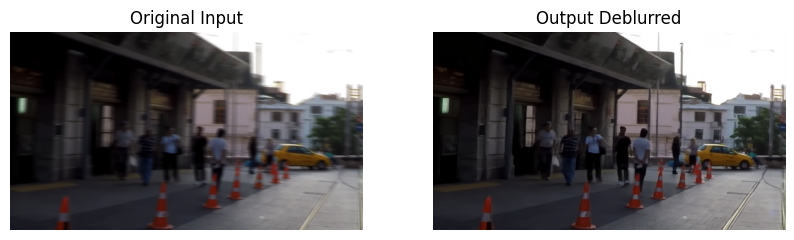

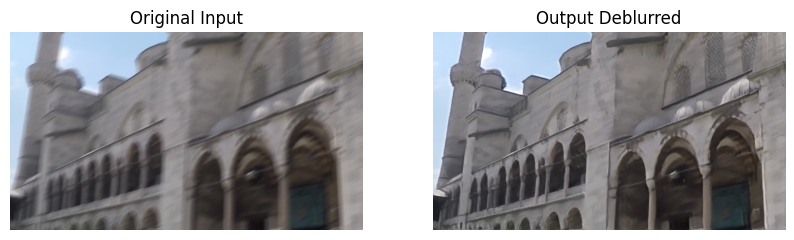

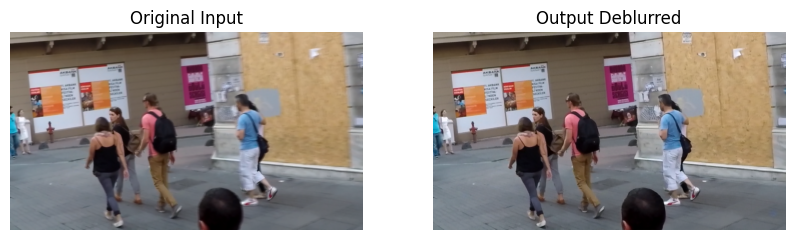

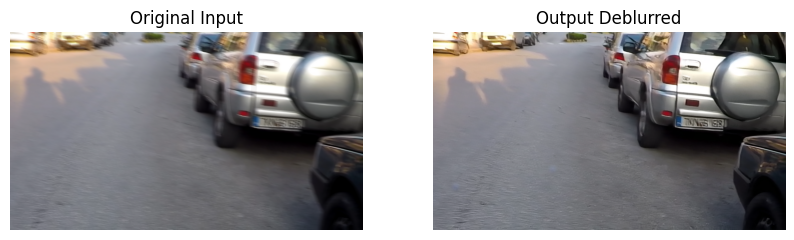

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_image_pairs(samples_dir, submit_dir):
    # Get list of image file names in samples directory
    sample_images = os.listdir(samples_dir)

    # Iterate over each image file
    for image_name in sample_images:
        if (".ipynb_checkpoints" in image_name):
            continue
        # Check if the corresponding image exists in the submit directory
        if os.path.exists(os.path.join(submit_dir, image_name)):
            # Load original input image from samples directory
            original_image_path = os.path.join(samples_dir, image_name)
            original_image = Image.open(original_image_path)

            # Load deblurred output image from submit directory
            deblurred_image_path = os.path.join(submit_dir, image_name)
            deblurred_image = Image.open(deblurred_image_path)

            # Plot the images side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original_image)
            axes[0].set_title("Original Input")
            axes[0].axis('off')

            axes[1].imshow(deblurred_image)
            axes[1].set_title("Output Deblurred")
            axes[1].axis('off')

            plt.show()

# Example usage
samples_folder = "/content/drive/MyDrive/final_exam_dl_k291/DeBlur/samples"
submit_folder = "/content/Colab-DeblurGANv2/submit"
plot_image_pairs(samples_folder, submit_folder)


## 2. Tiến hành tính toán độ sắc nét (sharpness) của hình ảnh trước và sau khi được deblur

### Visualize kết quả kèm theo độ sắc nét của hình ảnh trước và sau khi deblur

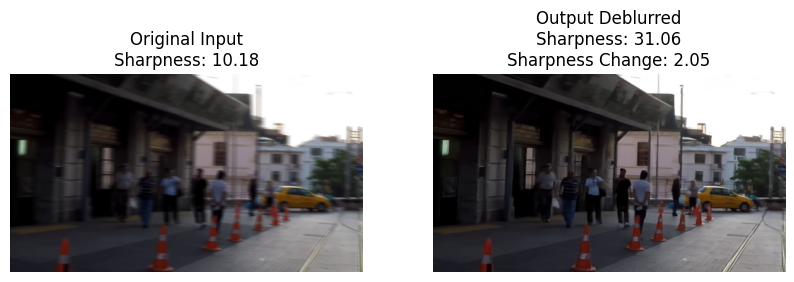

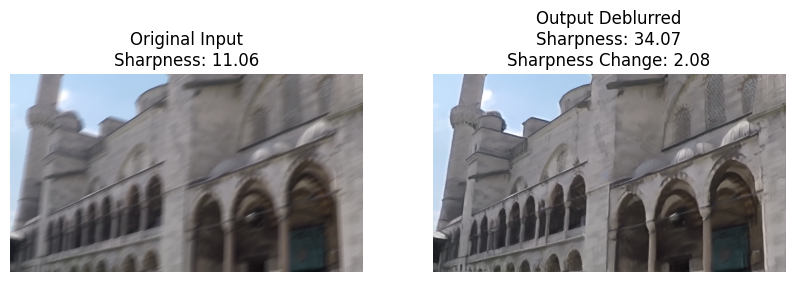

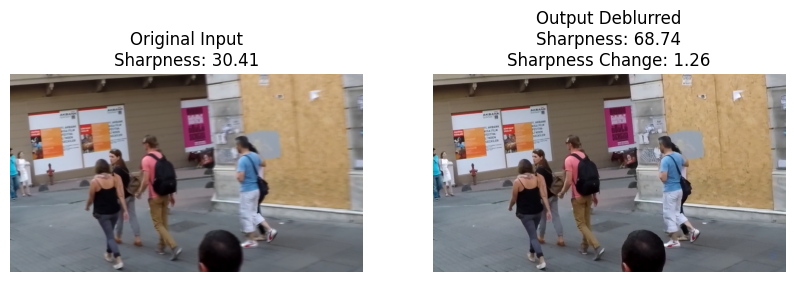

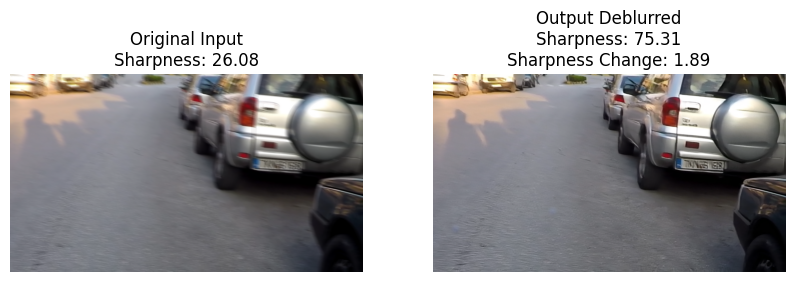

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

def calculate_sharpness(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Compute the Laplacian of the image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    # Compute the variance of Laplacian
    sharpness = laplacian.var()
    return sharpness

def plot_image_pairs(samples_dir, submit_dir):
    # Get list of image file names in samples directory
    sample_images = os.listdir(samples_dir)

    # Iterate over each image file
    for image_name in sample_images:
        if (".ipynb_checkpoints" in image_name):
            continue
        # Check if the corresponding image exists in the submit directory
        if os.path.exists(os.path.join(submit_dir, image_name)):
            # Load original input image from samples directory
            original_image_path = os.path.join(samples_dir, image_name)
            original_image = Image.open(original_image_path)
            original_image_array = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
            # Calculate sharpness of original image
            original_sharpness = calculate_sharpness(original_image_array)

            # Load deblurred output image from submit directory
            deblurred_image_path = os.path.join(submit_dir, image_name)
            deblurred_image = Image.open(deblurred_image_path)
            deblurred_image_array = cv2.cvtColor(np.array(deblurred_image), cv2.COLOR_RGB2BGR)
            # Calculate sharpness of deblurred image
            deblurred_sharpness = calculate_sharpness(deblurred_image_array)

            # Calculate rate of change in sharpness after deblurring
            sharpness_change = (deblurred_sharpness - original_sharpness)/original_sharpness

            # Plot the images side by side with sharpness and sharpness change in the title
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original_image)
            axes[0].set_title(f"Original Input\nSharpness: {original_sharpness:.2f}")
            axes[0].axis('off')

            axes[1].imshow(deblurred_image)
            axes[1].set_title(f"Output Deblurred\nSharpness: {deblurred_sharpness:.2f}\nSharpness Change: {sharpness_change:.2f}")
            axes[1].axis('off')

            plt.show()

# Example usage
samples_folder = "/content/drive/MyDrive/final_exam_dl_k291/DeBlur/samples"
submit_folder = "/content/Colab-DeblurGANv2/submit"
plot_image_pairs(samples_folder, submit_folder)


### Nhận xét:

Mô hình chạy nhanh chóng.

Mô hình chạy hiệu quả: mắt thường có thể thấy được hình ảnh sau xử lý rõ nét hơn rất nhiều

Dựa trên thông số sharpness: hình ảnh được tăng độ nét từ gấp 2 đến gấp trên gấp 3 lần, quá trình Deblur đã mang lại sự cải thiện đáng kể đối với độ nét của các hình ảnh:
- 2 hình đầu độ nét tăng cường rõ ràng: Độ nét tăng lên từ 10.18 lên đến 31.06 cho hình 1 và từ 11.6 lên 34.07 cho hình 2 => cải thiện đáng kể. Mô hình deblur đã làm rõ các chi tiết trong các hình ảnh này một cách hiệu quả.
- 2 hình sau độ nét tăng cường mạnh mẽ: Sự cải thiện của hình 3 và hình 4 là đặc biệt ấn tượng, với độ nét tăng lên từ 30.41 lên 68.74 cho hình 3 và từ 26.08 lên 75.31 cho hình 4. => mô hình deblur cải thiện mạnh mẽ đối với các hình ảnh ban đầu khá mờ.
- Hiệu suất đồng đều trên tất cả các hình ảnh: Mặc dù độ nét ban đầu của các hình ảnh khác nhau, mô hình vẫn xóa mờ có hiệu quả trên chúng nó, chất lượng cải thiện đồng điều và đáng kể

=> Mô hình thông minh và có hiệu quả tốt trong làm rõ nét hình ảnh